- 知识参考

[1] [强化学习之三：双臂赌博机（Two-armed Bandit）](https://blog.csdn.net/qq_32690999/article/details/78996390)

[2] [强化学习之四：基于策略的Agents (Policy-based Agents)](https://blog.csdn.net/qq_32690999/article/details/78996416)

[3] [Policy Gradients 思维决策 (Tensorflow)](https://morvanzhou.github.io/tutorials/machine-learning/reinforcement-learning/5-2-policy-gradient-softmax2/)

# Policy Based Agent (Policy Gradients Agent)

## 策略梯度（Policy Gradient）

- 必读的英文文章

http://karpathy.github.io/2016/05/31/rl/

[RL — Policy Gradient Explained](https://medium.com/@jonathan_hui/rl-policy-gradients-explained-9b13b688b146)

[An introduction to Policy Gradients with Cartpole and Doom](https://medium.freecodecamp.org/an-introduction-to-policy-gradients-with-cartpole-and-doom-495b5ef2207f)

Policy Gradients的nn的损失函数定义如下：

$$Loss=−log(π)∗A$$

A是优越度，也是所有强化学习算法的一个重要部分。直觉上，它描述了一个行动比某个基准线好多少。在未来的算法中，我们将遇到更复杂的用于比较回报的基准线，而现在我们就假设基准线为0，于是此处我们可以简单地把它想成我们采取每个行动对应的回报。

π是策略。在这个例子中，它和所选行动的权重相关。

我们将基于损失函数来对nn的参数进行更新：

  $$\theta=\theta+\bigtriangledown_\theta log(\pi(s,a))*A$$




In [ ]:
import gym
from RL_brain import PolicyGradient
import matplotlib.pyplot as plt

RENDER = False  # 在屏幕上显示模拟窗口会拖慢运行速度, 我们等计算机学得差不多了再显示模拟
DISPLAY_REWARD_THRESHOLD = 400  # 当 回合总 reward 大于 400 时显示模拟窗口

env = gym.make('CartPole-v0')   # CartPole 这个模拟
env = env.unwrapped     # 取消限制
env.seed(1)     # 普通的 Policy gradient 方法, 使得回合的 variance 比较大, 所以我们选了一个好点的随机种子

print(env.action_space)     # 显示可用 action
print(env.observation_space)    # 显示可用 state 的 observation
print(env.observation_space.high)   # 显示 observation 最高值
print(env.observation_space.low)    # 显示 observation 最低值

# 定义
RL = PolicyGradient(
    n_actions=env.action_space.n,
    n_features=env.observation_space.shape[0],
    learning_rate=0.02,
    reward_decay=0.99,   # gamma
    # output_graph=True,    # 输出 tensorboard 文件
)


for i_episode in range(3000):

    observation = env.reset()

    while True:
        if RENDER: env.render()

        action = RL.choose_action(observation)

        observation_, reward, done, info = env.step(action)

        RL.store_transition(observation, action, reward)    # 存储这一回合的 transition

        if done:
            ep_rs_sum = sum(RL.ep_rs)

            if 'running_reward' not in globals():
                running_reward = ep_rs_sum
            else:
                running_reward = running_reward * 0.99 + ep_rs_sum * 0.01
            if running_reward > DISPLAY_REWARD_THRESHOLD: RENDER = True     # 判断是否显示模拟
            print("episode:", i_episode, "  reward:", int(running_reward))

            vt = RL.learn() # 学习, 输出 vt, 我们下节课讲这个 vt 的作用

            if i_episode == 0:
                plt.plot(vt)    # plot 这个回合的 vt
                plt.xlabel('episode steps')
                plt.ylabel('normalized state-action value')
                plt.show()
            break

        observation = observation_

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Box(4,)
Box(24,)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

episode: 0   reward: -121
None


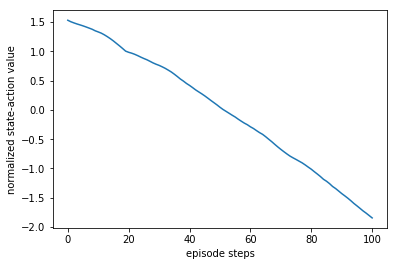

episode: 1   reward: -121
None
episode: 2   reward: -120
None
episode: 3   reward: -120
None
episode: 4   reward: -120
None
episode: 5   reward: -120
None
episode: 6   reward: -120
None
episode: 7   reward: -120
None
episode: 8   reward: -120
None
episode: 9   reward: -121
None
episode: 10   reward: -121
None
episode: 11   reward: -121
None
episode: 12   reward: -121
None
episode: 13   reward: -121
None
episode: 14   reward: -121
None
episode: 15   reward: -121
None
episode: 16   reward: -121
None
episode: 17   reward: -121
None
episode: 18   reward: -121
None
episode: 19   reward: -122
None
episode: 20   reward: -122
None
episode: 21   reward: -122
None
episode: 22   reward: -122
None
episode: 23   reward: -122
None
episode: 24   reward: -122
None
episode: 25   reward: -122
None
episode: 26   reward: -122
None
episode: 27   reward: -122
None
episode: 28   reward: -122
None
episode: 29   reward: -122
None
episode: 30   reward: -122
None
episode: 31   reward: -123
None
episode: 32   rew

KeyboardInterrupt: 

In [1]:
"""
Policy Gradient, Reinforcement Learning.
The cart pole example
View more on my tutorial page: https://morvanzhou.github.io/tutorials/
Using:
Tensorflow: 1.0
gym: 0.8.0
"""

"""
This part of code is the reinforcement learning brain, which is a brain of the agent.
All decisions are made in here.
Policy Gradient, Reinforcement Learning.
View more on my tutorial page: https://morvanzhou.github.io/tutorials/
Using:
Tensorflow: 1.0
gym: 0.8.0
"""

import numpy as np
import tensorflow as tf
import gym
# from gym import spaces

# reproducible
np.random.seed(1)
tf.set_random_seed(1)
tf.reset_default_graph() 

class PolicyGradient:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate=0.01,
            reward_decay=0.95,
            output_graph=False,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay

        self.ep_obs, self.ep_as, self.ep_rs = [], [], []

        self._build_net()

        self.sess = tf.Session()

        if output_graph:
            # $ tensorboard --logdir=logs
            # http://0.0.0.0:6006/
            # tf.train.SummaryWriter soon be deprecated, use following
            tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())

    def _build_net(self):
        with tf.name_scope('inputs'):
            self.tf_obs = tf.placeholder(tf.float32, [None, self.n_features], name="observations")
            self.tf_acts = tf.placeholder(tf.int32, [None, self.n_actions], name="actions_num")
            self.tf_vt = tf.placeholder(tf.float32, [None, ], name="actions_value")
        # fc1
        with tf.name_scope('nn'):
            layer = tf.layers.dense(
                inputs=self.tf_obs,
                units=20,
                activation=tf.nn.tanh,  # tanh activation
                kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.3),
                bias_initializer=tf.constant_initializer(0.1),
                name='fc1',
            )
            # fc2
            all_act = tf.layers.dense(
                inputs=layer,
                units=self.n_actions,
                activation=None,
                kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.3),
                bias_initializer=tf.constant_initializer(0.1),
                name='fc2',
            )

#         self.all_act_prob = tf.nn.softmax(all_act, name='act_prob')  # use softmax to convert to probability

        with tf.name_scope('loss'):
            # to maximize total reward (log_p * R) is to minimize -(log_p * R), and the tf only have minimize(loss)
#             neg_log_prob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=all_act, labels=self.tf_acts)   # this is negative log of chosen action
            neg_log_prob = tf.nn.softmax_cross_entropy_with_logits(logits=all_act, labels=self.tf_acts)   
    
            # or in this way:
            # neg_log_prob = tf.reduce_sum(-tf.log(self.all_act_prob)*tf.one_hot(self.tf_acts, self.n_actions), axis=1)
            loss = tf.reduce_mean(neg_log_prob * self.tf_vt)  # reward guided loss

        with tf.name_scope('train'):
            self.train_op = tf.train.AdamOptimizer(self.lr).minimize(loss)
            self.mu=all_act
            self.sigma=tf.constant(1.0, shape=[1,self.n_actions])

    def choose_action(self,observation):
#         prob_weights = self.sess.run(self.all_act_prob, feed_dict={self.tf_obs: observation[np.newaxis, :]})
#         action = np.random.choice(range(prob_weights.shape[1]), p=prob_weights.ravel())  # select action w.r.t the actions prob
        mu=self.sess.run(self.mu,feed_dict={self.tf_obs: observation[np.newaxis, :]})[0] # shape: 1*4
        sigma=self.sess.run(self.sigma)[0] # shape: 1*4
        action=np.random.normal(mu, sigma)
        return action

    def store_transition(self, s, a, r):
        self.ep_obs.append(s)
        self.ep_as.append(a)
        self.ep_rs.append(r)

    def learn(self):
        # discount and normalize episode reward
        discounted_ep_rs_norm = self._discount_and_norm_rewards()

        # train on episode
        self.sess.run(self.train_op, feed_dict={
             self.tf_obs: np.vstack(self.ep_obs),  # shape=[None, n_obs]
             self.tf_acts: np.array(self.ep_as),  # shape=[None, ]
             self.tf_vt: discounted_ep_rs_norm,  # shape=[None, ]
        })
        
        print("learn:")
        print('self.tf_acts:')_
        print(np.array(self.ep_as))
        print('self.tf_obs:')
        print(np.vstack(self.ep_obs))
        

        self.ep_obs, self.ep_as, self.ep_rs = [], [], []    # empty episode data
        return discounted_ep_rs_norm

    def _discount_and_norm_rewards(self):
        # discount episode rewards
        discounted_ep_rs = np.zeros_like(self.ep_rs)
        running_add = 0
        for t in reversed(range(0, len(self.ep_rs))):
            running_add = running_add * self.gamma + self.ep_rs[t]
            discounted_ep_rs[t] = running_add

        # normalize episode rewards
        discounted_ep_rs -= np.mean(discounted_ep_rs)
        discounted_ep_rs /= np.std(discounted_ep_rs)
        return discounted_ep_rs

    
    
    
    
import matplotlib.pyplot as plt

# hyperparameters

MAX_EPISODES=3000
DISPLAY_REWARD_THRESHOLD = -110  # renders environment if total episode reward is greater then this threshold
RENDER = False  # rendering wastes time

# env_name='CartPole-v0'
env_name='BipedalWalker-v2'
env = gym.make(env_name)
env.seed(1)     # reproducible, general Policy gradient has high variance
env = env.unwrapped

print(env.action_space)
print(env.observation_space)

RL = PolicyGradient(
    n_actions=env.action_space.shape[0],
    n_features=env.observation_space.shape[0],
    learning_rate=0.02,
    reward_decay=0.99,
    # output_graph=True,
)



for i_episode in range(MAX_EPISODES):

    observation = env.reset()
    
    while True:
        if RENDER: env.render()

        action = RL.choose_action(observation)
        
        observation_, reward, done, info = env.step(action)
        
        RL.store_transition(observation, action, reward)


        if done:
            ep_rs_sum = sum(RL.ep_rs)

            if 'running_reward' not in globals():
                running_reward = ep_rs_sum
            else:
                running_reward = running_reward * 0.99 + ep_rs_sum * 0.01
            if running_reward > DISPLAY_REWARD_THRESHOLD: RENDER = True     # rendering
            print("episode:", i_episode, "  reward:", int(running_reward))

            vt = RL.learn()

            if i_episode == 0:
                plt.plot(vt)    # plot the episode vt
                plt.xlabel('episode steps')
                plt.ylabel('normalized state-action value')
                plt.show()
            break

        observation = observation_